In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
N_CLASSES  = 3
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "potato-data",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE)
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

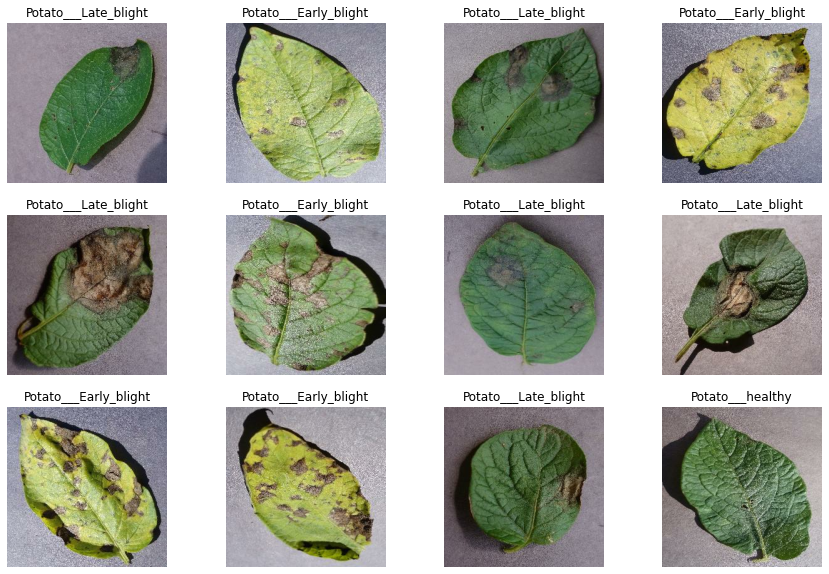

In [5]:
plt.figure(figsize=(15, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(dataset, train_size=.8, validation_size=.1, test_size=.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_size*dataset_size)
    validation_size = int(validation_size*dataset_size)
    
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    return train_dataset, validation_dataset, test_dataset

In [7]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [8]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
54/54 [==============================] - 23s 192ms/step - loss: 0.9036 - accuracy: 0.4988 - val_loss: 0.8366 - val_accuracy: 0.7135
Epoch 2/20
54/54 [==============================] - 9s 169ms/step - loss: 0.7576 - accuracy: 0.6441 - val_loss: 0.4549 - val_accuracy: 0.8073
Epoch 3/20
54/54 [==============================] - 9s 169ms/step - loss: 0.4240 - accuracy: 0.8333 - val_loss: 0.4566 - val_accuracy: 0.7656
Epoch 4/20
54/54 [==============================] - 9s 169ms/step - loss: 0.3527 - accuracy: 0.8611 - val_loss: 0.2593 - val_accuracy: 0.8906
Epoch 5/20
54/54 [==============================] - 9s 169ms/step - loss: 0.2786 - accuracy: 0.8843 - val_loss: 0.4082 - val_accuracy: 0.8177
Epoch 6/20
54/54 [==============================] - 9s 169ms/step - loss: 0.2023 - accuracy: 0.9178 - val_loss: 0.2769 - val_accuracy: 0.8698
Epoch 7/20
54/54 [==============================] - 9s 169ms/step - loss: 0.1834 - accuracy: 0.9277 - val_loss: 0.1265 - val_accuracy: 0.9531
Epoch

In [14]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 2s 70ms/step - loss: 0.0653 - accuracy: 0.9844


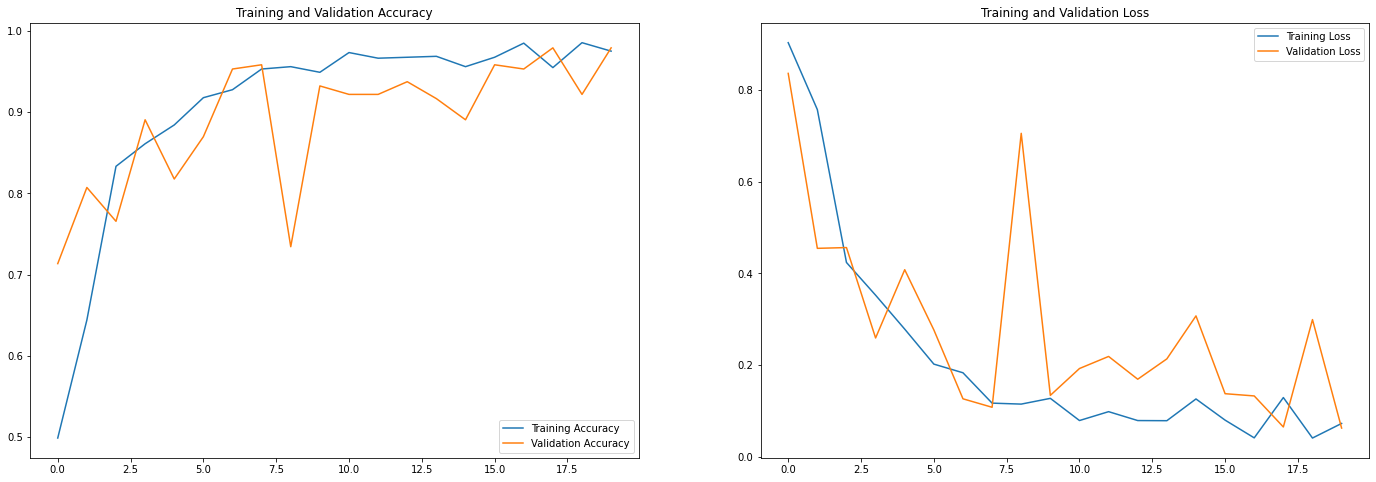

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual label: Potato___Late_blight
Predicted label: Potato___Late_blight
correct


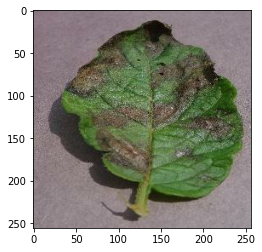

In [16]:
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    print("correct" if class_names[first_label] == class_names[np.argmax(batch_prediction[0])] else "wrong")

In [17]:
def predict(model):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

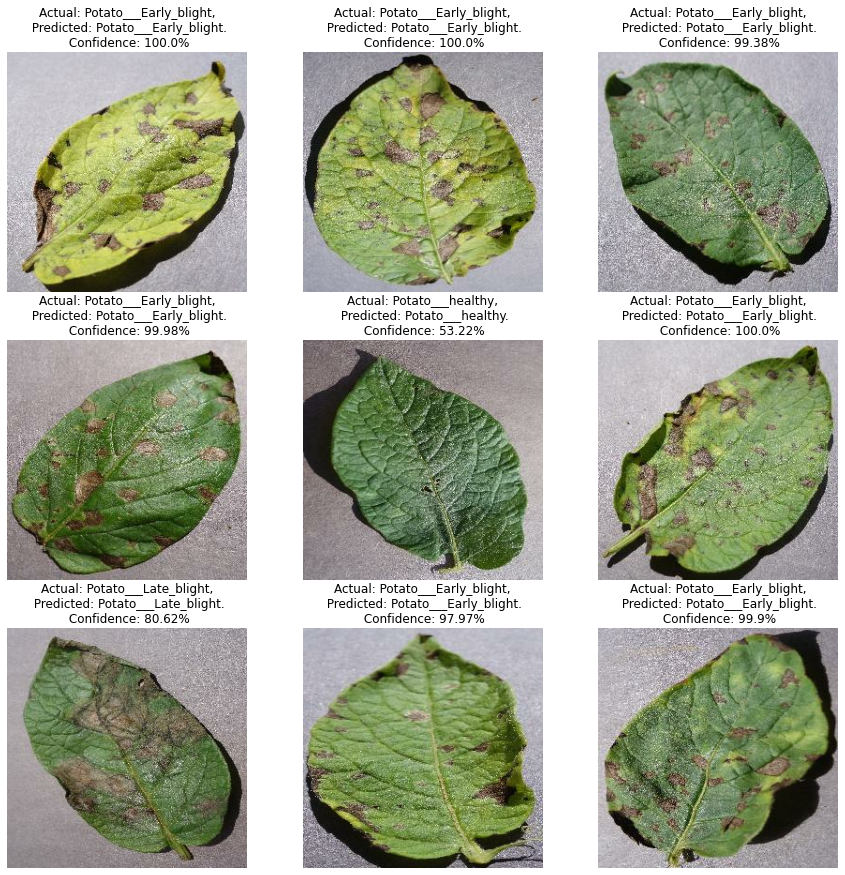

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model)
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [19]:
model_version = 1
model.save(f"../models/potato_{model_version}")

INFO:tensorflow:Assets written to: ../models/potato_1\assets
